# Project - Early Warning System for Forest Fire

This project aims to develop an early warning system for forest fires using a Convolutional Neural Network (CNN) model. The CNN model will be trained to classify whether an input image contains fire or not. The dataset used for training the model will consist of images of forests and will be labelled with binary classes (fire and non-fire).

The developed CNN model will be capable of identifying the presence of fire in real-time, which can be crucial in preventing large-scale forest fires. The system can be used by forest rangers, firefighters, and other relevant authorities to take immediate action and prevent the spread of fire.

The project will involve data collection, preprocessing, and cleaning, followed by building and training the CNN model using the PyTorch framework. The performance of the model will be evaluated using various metrics such as accuracy, precision, recall, and F1-score.

In [127]:
# Import the necessary libraries

import torch
from torch import nn, flatten
from torch.nn import Module
import glob
from torch.utils.data import DataLoader, Dataset, random_split
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import Adam
from torchsummary import summary
import random
from sklearn.metrics import classification_report
import torchvision.transforms as transforms
from torch.nn import Conv2d, Linear, MaxPool2d, ReLU, AdaptiveMaxPool2d, LogSoftmax, BatchNorm2d, Dropout
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [128]:
# Mount gdrive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Check the device

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Importing Images

This code is used for loading and preprocessing image data for Fire Vs Non-Fire Classification. The code reads the dataset from a specified path and splits the data into two sets, the training/validation set and the testing set. The images are resized to the dimensions of 90x90 and converted to RGB format. The code also handles any errors while reading the images. Finally, the image data is stored in separate lists for training/validation and testing with their corresponding labels.

In [131]:
# Initializing empty lists for storing image data and their labels for training and testing

train_img_data = []
test_img_data = []

# Set the image dimensions
x_dim = 90
y_dim = 90

# Define the path where the dataset is stored
imgs_path = "drive/MyDrive/FireVsNonFire/"

# Get a list of all the files in the dataset folder
file_list = glob.glob(imgs_path + "*")

# Print the list of files in the dataset folder
print("1:   ", file_list)

# Loop through each file in the dataset folder
for splits_path in file_list:

    # Get a list of all the subfolders in the file
    split_file_list = glob.glob(splits_path + "/" + "*")

    # Print the list of subfolders in the file
    print("2:   ", split_file_list)

    # Get the split type (training/validation or testing) from the file path
    split_type = splits_path.split("/")[-1]

    # Loop through each subfolder in the file
    for folder in split_file_list:

        # Get the class label from the subfolder name
        this_class = folder.split("/")[-1]
        print(this_class)

        # Get a list of all the images in the subfolder
        images = glob.glob(folder + "/*")

        # Loop through each image in the subfolder
        for img in images:
            
            try: 
                # Read the image and resize it to the specified dimensions
                read_image = cv2.imread(img)
                read_image = cv2.cvtColor(read_image, cv2.COLOR_BGR2RGB)
                read_image = cv2.resize(read_image, (x_dim, y_dim))
            
            except:
                # Skip any images that cannot be read or resized
                continue           

            # Append the image data and its corresponding class label to either the training/validation list or the testing list
            if split_type == "Training and Validation":
                train_img_data.append({'image': read_image, 'class': this_class})
            elif split_type == "Testing":
                test_img_data.append({'image': read_image, 'class': this_class})


1:    ['drive/MyDrive/FireVsNonFire/Testing', 'drive/MyDrive/FireVsNonFire/Training and Validation']
2:    ['drive/MyDrive/FireVsNonFire/Testing/fire', 'drive/MyDrive/FireVsNonFire/Testing/nofire']
fire
nofire
2:    ['drive/MyDrive/FireVsNonFire/Training and Validation/fire', 'drive/MyDrive/FireVsNonFire/Training and Validation/nofire']
fire
nofire


(90, 90, 3)
2340
906


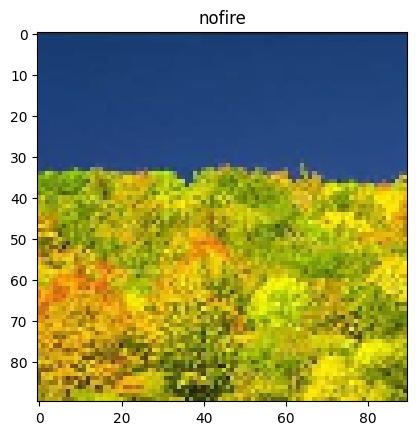

In [132]:
# Select a random image from the training dataset
x = random.randint(0, len(train_img_data)-1)

# Display the shape and image of the selected image
print(train_img_data[x]['image'].shape)
plt.imshow(train_img_data[x]['image'])
plt.title(train_img_data[x]['class'])

# Print the length of the training and testing datasets
print(len(train_img_data))
print(len(test_img_data))


### Initializng DataLoader

The dataset takes in two arguments: 'data', which is a list of image and class pairs, and 'augment', a boolean value that determines whether or not data augmentation should be performed on the images.

The class dictionary attribute maps the class names to numerical labels. If 'augment' is True, the images are augmented using a set of transformations defined by the 'augmentImages' variable. The augmented images are then added to the original dataset.

Inside getitem, the image is converted to a PyTorch tensor and the label is mapped to its numerical label using the class dictionary attribute.

In [133]:
class FireDataset(Dataset):

    def __init__(self, data, augment):
        self.class_dict = {'nofire': 0, 'fire': 1} # a dictionary mapping class names to class labels
        self.data = data # the list of data
        before_aug = len(self.data) # the number of items in the data list before augmentation
        
        # define the sequence of image transformations to apply for data augmentation
        augmentImages = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomAutocontrast(p=0.7),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.ToTensor()
        ])

        # apply data augmentation if the augment flag is True
        if (augment):
            augmentImagesData = []

            # loop over each item in the data list
            for image_info in self.data:
                image = image_info['image']
                class_name = image_info['class']
                
                # apply the defined sequence of transformations to the image
                aug_image = augmentImages(image).squeeze(0).numpy().T
                augmentImagesData.append({'image': aug_image, 'class': class_name})
            
            # add the augmented images to the data list
            self.data = self.data + augmentImagesData
            
            after_aug = len(self.data) # the number of items in the data list after augmentation
            print(before_aug, " : ", after_aug)
            
            # print the shapes of two example images after augmentation
            print(self.data[2254]['image'].shape)
            print(self.data[898]['image'].shape)

            # plot two example images after augmentation
            plt.imshow(self.data[2100]['image'])
            plt.figure()
            plt.imshow(self.data[25]['image'])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = self.data[index]['image'] # get the image data
        image_class = self.data[index]['class'] # get the image class

        image = torch.from_numpy(image) # convert the image data to a PyTorch tensor

        image_class = self.class_dict[image_class] # map the image class name to its corresponding label

        return (image.float(), image_class) # return a tuple containing the image data and its corresponding class label


### Get Loaders

The dataset object is split into training and testing data with a 70:30 ratio, where the training data is randomly shuffled. The train_dataset and test_dataset are then created using the FireDataset class with train_img_data and test_img_data respectively.

Finally, the trainLoader and testLoader objects are created using the DataLoader class, with the train_dataset and test_dataset respectively.

2340  :  4680
(90, 90, 3)
(90, 90, 3)


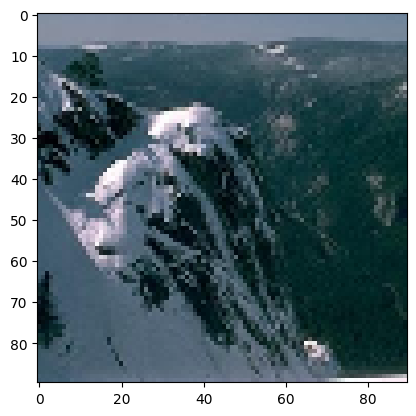

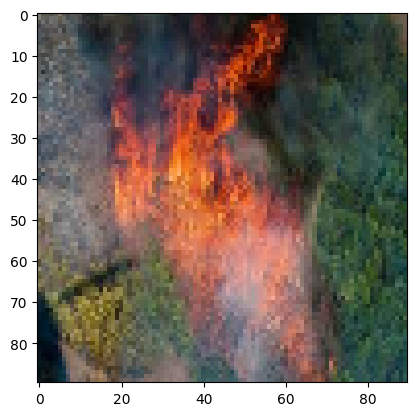

In [134]:
# Define the batch size and number of channels
batch_size = 32
num_channels = 3

# Define a function to return DataLoader objects for training and testing data
def getLoaders(dataset, batch_size):
    
    # Split the dataset into training and testing sets
    numTrain = int(0.7 * (len(dataset)))    # 70% of the data for training
    numTest = int(len(dataset) - numTrain)  # Remaining 30% for testing
    (trainData, testData) = random_split(dataset, [numTrain, numTest], generator=torch.Generator().manual_seed(42))
    
    # Print the training data (for debugging purposes)
    print(trainData)
    
    # Create DataLoader objects for the training and testing sets
    trainLoader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)
    testLoader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)
    
    # Return the DataLoader objects along with the number of items in each split
    return trainLoader, testLoader, numTrain, numTest

# Create FireDataset objects for the training and testing image data
train_dataset = FireDataset(train_img_data, True)
test_dataset = FireDataset(test_img_data, False)

# Get DataLoader objects for the training and testing datasets
trainLoader, testLoader, numTrain, numTest = getLoaders(train_dataset, batch_size)

### Visualize DataLoaders

The first block defines a set of image augmentations using PyTorch's transforms.Compose method. The set includes horizontal and vertical flips, autocontrast, Gaussian blur, random erasing, random rotation, color jitter, and normalization. These augmentations will be applied to the images in the second layer before merging.

The second block defines a custom neural network architecture for fire detection using PyTorch's nn.Module. The architecture includes two convolutional layers, a stack of convolutional layers, and a stack of linear layers. The forward method performs a forward pass through the network. In the forward pass, the same input image is sent through two different layers, with the second copy potentially augmented using the set of augmentations defined in the previous cell. The output of the two convolutional layers is added together in an early merge step, before passing through the stack of convolutional and linear layers. The final output is a LogSoftmax activation function with dropout applied in between the linear layers.

In [ ]:
# Define the augmentations for images in the second layer before merging.

augmentImages = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),
    transforms.RandomAutocontrast(p=1),
    transforms.RandomVerticalFlip(p=1),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.RandomErasing(p=1, scale=(0.02, 0.33), ratio=(0.3, 3.3), value='random'),
    transforms.RandomRotation(degrees=(-45, 45)),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.4),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [137]:
class FireDetectionCNN(Module):
    
    def __init__(self) -> None:
        super(FireDetectionCNN, self).__init__()

        # Define convolutional layers
        
        self.convlayer1 = nn.Sequential(
            Conv2d(in_channels=num_channels, out_channels=20,
                   kernel_size=(2, 2), stride=(2, 2)),
            ReLU(),
            MaxPool2d(kernel_size=(3, 3)),
            BatchNorm2d(20)
        )

        self.convlayer2 = nn.Sequential(
            Conv2d(in_channels=num_channels, out_channels=20,
                   kernel_size=(2, 2), stride=(2, 2)),
            ReLU(),
            MaxPool2d(kernel_size=(3, 3)),
            BatchNorm2d(20)
        )

        self.convstack1 = nn.Sequential(
            Conv2d(in_channels=20, out_channels=48, kernel_size=(2, 2)),
            ReLU(),
            MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            Conv2d(in_channels=48, out_channels=48, kernel_size=(2, 2)),
            ReLU(),
            BatchNorm2d(48)
        )

        # Define linear layers

        self.LinearStack1 = nn.Sequential(
            Linear(in_features=1728, out_features=700),
            ReLU(),
            Dropout(0.2),
            Linear(in_features=700, out_features=80),
            ReLU(),
            Dropout(0.2),
            Linear(in_features=80, out_features=2),
            LogSoftmax(dim=1),
            Dropout(0.2)
        )

    def forward(self, x):

        # Perform forward pass
        # Augment the input image with a 70% probability and send through two different layers
        # Early Merge the results

        x2 = x.clone()
        if random.random() <= 0.7: # Augment with 70% probability
          augmentImages(x2)

        x1 = self.convlayer1(x)
        x2 = self.convlayer2(x2)
        x = x1 + x2 # Early Merge

        x = self.convstack1(x)
        x = flatten(x, 1)
        x = self.LinearStack1(x)

        return x

### Training the Model

The learning rate is set to 0.0003, and the number of epochs is set to 20. An Adam optimizer is defined with the specified learning rate and the model parameters. The loss function is set to negative log-likelihood loss.

The training loop is executed for the specified number of epochs. Inside the loop, the train loader is iterated over and the input and target data are extracted. The input data is reshaped to have the batch size as the first dimension and moved to the GPU. The forward pass is performed using the model and the loss is calculated using the negative log-likelihood loss function. The optimizer's gradients are zeroed, and the loss gradients are backpropagated. The optimizer is updated using the step() method. The training loss is accumulated for each batch.

After each epoch, the training loss is printed. At the end of the training, the final training loss is printed.

In [138]:
# Define the CNN model for fire detection and move it to the specified device
model = FireDetectionCNN().to(device)

# Define the learning rate and number of epochs
learning_rate = 0.0003
epochs = 20

# Define the Adam optimizer with the specified learning rate and the negative log-likelihood loss function
opt = Adam(model.parameters(), lr=learning_rate)
lossFn = nn.NLLLoss()

print("FireDetectionCNN - Training has started")

# Set the model to training mode
model.train()

# Loop over the number of epochs
for epoch in range(epochs):
    # Initialize the training loss for this epoch
    trainLoss = 0

    # Loop over the training data loader
    for (x, y) in trainLoader:
        # Flatten the label tensor and cast it to a long tensor
        y = (y.flatten()).type(torch.LongTensor)
        # Reshape the input tensor and move both the input and label tensors to the specified device
        x = x.view(batch_size, num_channels, x_dim, y_dim)
        (x, y) = (x.to(device), y.to(device))

        # Forward propagate the input tensor through the model and compute the loss
        pred = model(x)
        loss = lossFn(pred, y)

        # Zero out the gradients, backpropagate the loss, and update the model parameters
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Add the current batch's loss to the running total for this epoch
        trainLoss += loss

    print("[EPOCH : %1d ----- Loss : %.4f]" % (epoch, trainLoss.item()))

print("FireDetectionCNN - Training has finished.... Final Loss: %.4f" % (trainLoss.item()))

FireDetectionCNN - Training has started
[EPOCH : 0 ----- Loss : 74.5705]
[EPOCH : 1 ----- Loss : 67.8352]
[EPOCH : 2 ----- Loss : 59.8208]
[EPOCH : 3 ----- Loss : 60.4503]
[EPOCH : 4 ----- Loss : 58.0403]
[EPOCH : 5 ----- Loss : 53.3221]
[EPOCH : 6 ----- Loss : 52.0353]
[EPOCH : 7 ----- Loss : 51.6207]
[EPOCH : 8 ----- Loss : 49.8663]
[EPOCH : 9 ----- Loss : 49.5668]
[EPOCH : 10 ----- Loss : 48.2262]
[EPOCH : 11 ----- Loss : 45.9688]
[EPOCH : 12 ----- Loss : 43.8580]
[EPOCH : 13 ----- Loss : 45.0691]
[EPOCH : 14 ----- Loss : 42.9695]
[EPOCH : 15 ----- Loss : 43.7655]
[EPOCH : 16 ----- Loss : 43.0091]
[EPOCH : 17 ----- Loss : 43.1794]
[EPOCH : 18 ----- Loss : 41.1524]
[EPOCH : 19 ----- Loss : 39.3776]
FireDetectionCNN - Training has finished.... Final Loss: 39.3776


### Evaluation

The code evaluates the performance of a trained model on a test dataset. The accuracy of the model is calculated and a confusion matrix is generated using the classification_report and confusion_matrix functions from the sklearn.metrics module. The accuracy and confusion matrix are then plotted using the sn.heatmap function from the seaborn module. Additionally, the code checks which "fire" images are being incorrectly classified and stores them in the incorrect_classified list.

Accuracy :  0.9609
              precision    recall  f1-score   support

        Fire       0.97      0.98      0.97       673
     No Fire       0.94      0.90      0.92       223

    accuracy                           0.96       896
   macro avg       0.95      0.94      0.95       896
weighted avg       0.96      0.96      0.96       896

896
[[661  23]
 [ 12 200]]


<Axes: title={'center': 'Confusion Matrix'}>

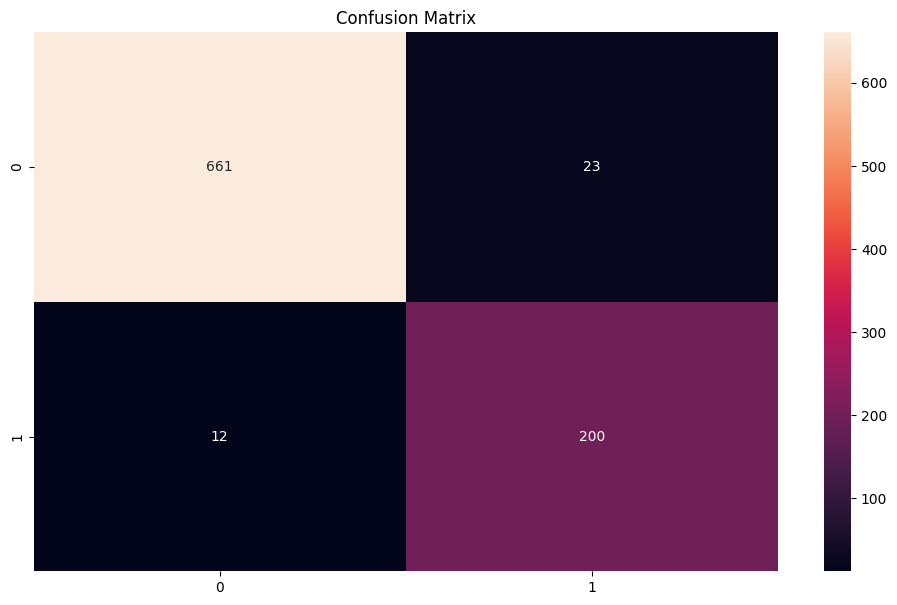

In [139]:
# Put the model in evaluation mode
with torch.no_grad():
    model.eval()
    
    # Initialize variables for tracking test accuracy and predictions
    testCorrect = 0
    preds = []
    ground_labels = []
    incorrect_classified = []

    # Loop through each test data batch
    for (x, y) in testLoader:
        
        # Flatten the label data and convert it to a LongTensor
        y = (y.flatten()).type(torch.LongTensor)
        
        # Reshape the input data
        x = x.view(batch_size, num_channels, x_dim, y_dim)

        # Send the input and label data to the device
        (x, y) = (x.to("cuda"), y.to("cuda"))

        # Make a prediction for the current batch of input data
        pred = model(x)
        preds.append(pred.argmax(1))

        # Append the ground truth label to a list for later use
        ground_labels.append(y)

        # Checking which "fire" images are being incorrectly classified
        for i,pic in enumerate(x):
            if y[i] == 1:
                if pred[i].argmax() != 1:
                    incorrect_classified.append(pic)

        # Calculate the number of correct predictions for the current batch
        testCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()

    # Flatten the list of predictions and ground truth labels
    preds = torch.flatten(torch.stack(preds))
    ground_labels = torch.flatten(torch.stack(ground_labels))

    # Print the test accuracy
    print("Accuracy :  %.4f" % (testCorrect/len(ground_labels)))

    # Define the class names for the classification report
    target_names = ['Fire', 'No Fire']

    # Print the classification report
    print(classification_report(preds.cpu().numpy(),
          ground_labels.cpu().numpy(), target_names=target_names))

    # Print the number of ground truth labels
    print(len(ground_labels))

    # Calculate the confusion matrix and plot it as a heatmap
    cm = confusion_matrix(ground_labels.cpu(), preds.cpu())
    plt.figure(figsize = (12,7))
    plt.title("Confusion Matrix")
    sn.heatmap(cm, annot=True, fmt='.0f')

12
(90, 90, 3)


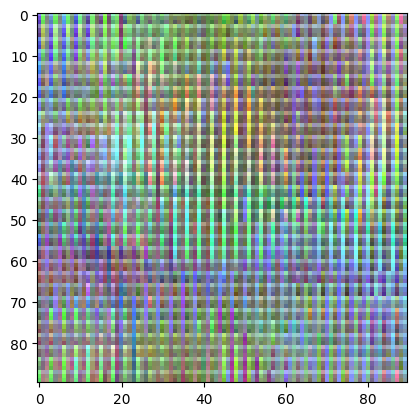

In [ ]:
# Checking the incorrectly classified images

rand_int = random.randint(0,len(incorrect_classified)-1)

print(len(incorrect_classified))

image_incorrect = incorrect_classified[rand_int].cpu()

#image_incorrect = image_incorrect.view(200,200,1)
image_incorrect = image_incorrect.numpy().T
print(image_incorrect.shape)

plt.imshow(image_incorrect/255)